# Approach 2: Neural Network on Hand Landmarks

**Data:** 63 features (21 landmarks × 3 coords) → 29 classes

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.1


In [2]:
# Load and prepare data
df = pd.read_csv('../data/asl_landmarks_train.csv')
df_clean = df.dropna()

X = df_clean.drop('label', axis=1).values
y = df_clean['label'].values

print(f"Samples: {len(X)} | Features: {X.shape[1]} | Classes: {len(np.unique(y))}")

Samples: 63616 | Features: 63 | Classes: 29


In [3]:
# Encode labels & split data
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 50892 | Test: 12724


In [4]:
# Normalize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Build neural network
num_classes = len(label_encoder.classes_)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(63,)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/daml-asl/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333 (71.61 KB)

 Trainable params: 18,333 (71.61 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.7943 - loss: 0.7082 - val_accuracy: 0.9669 - val_loss: 0.1510
Epoch 2/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.9365 - loss: 0.2213 - val_accuracy: 0.9695 - val_loss: 0.1186
Epoch 3/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.9537 - loss: 0.1664 - val_accuracy: 0.9807 - val_loss: 0.0804
Epoch 4/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - accuracy: 0.9627 - loss: 0.1399 - val_accuracy: 0.9814 - val_loss: 0.0748
Epoch 5/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.9666 - loss: 0.1219 - val_accuracy: 0.9829 - val_loss: 0.0647
Epoch 6/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9671 - loss: 0.1169 - val_accuracy: 0.9846 - val_loss: 0.0602
Epoch 7/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.9700 - loss: 0.1058 - val_accuracy: 0.9825 - val_loss: 0.0620
Epoch 8/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9727 -

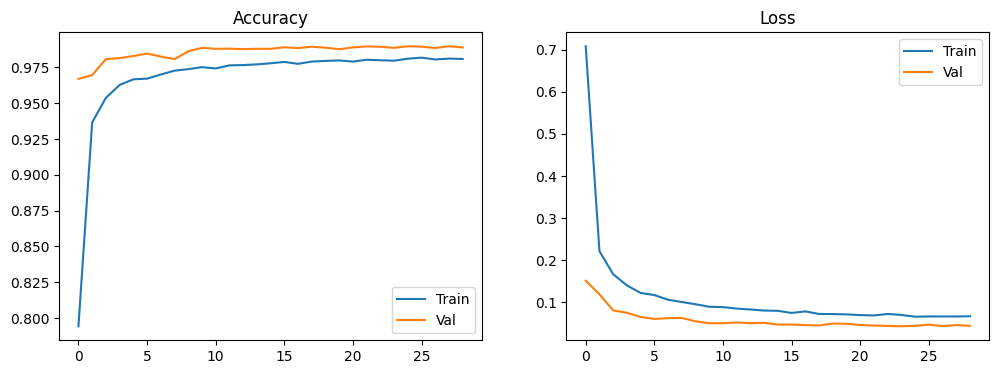

In [7]:
# Plot training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy'); ax1.legend()
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss'); ax2.legend()
plt.show()

In [8]:
# Evaluate
_, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 98.88%


In [10]:
# Classification report
y_pred = model.predict(X_test_scaled).argmax(axis=1)

# Only show classes that actually exist in the test set
unique_classes = sorted(set(y_test))
class_names_filtered = [label_encoder.classes_[i] for i in unique_classes]

print(classification_report(y_test, y_pred, labels=unique_classes, target_names=class_names_filtered))

398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
              precision    recall  f1-score   support

           A       0.99      1.00      0.99       437
           B       0.99      1.00      1.00       441
           C       0.99      1.00      0.99       398
           D       1.00      0.98      0.99       493
           E       0.99      1.00      1.00       462
           F       1.00      0.99      1.00       575
           G       0.99      0.99      0.99       488
           H       1.00      1.00      1.00       479
           I       0.99      1.00      0.99       473
           J       1.00      0.99      0.99       516
           K       1.00      0.99      0.99       540
           L       1.00      1.00      1.00       505
           M       0.88      0.97      0.92       313
           N       0.99      0.83      0.90       253
           O       0.98      1.00      0.99       453
           P       1.00      0.99      0.99       408
           Q       0.99      0.99     

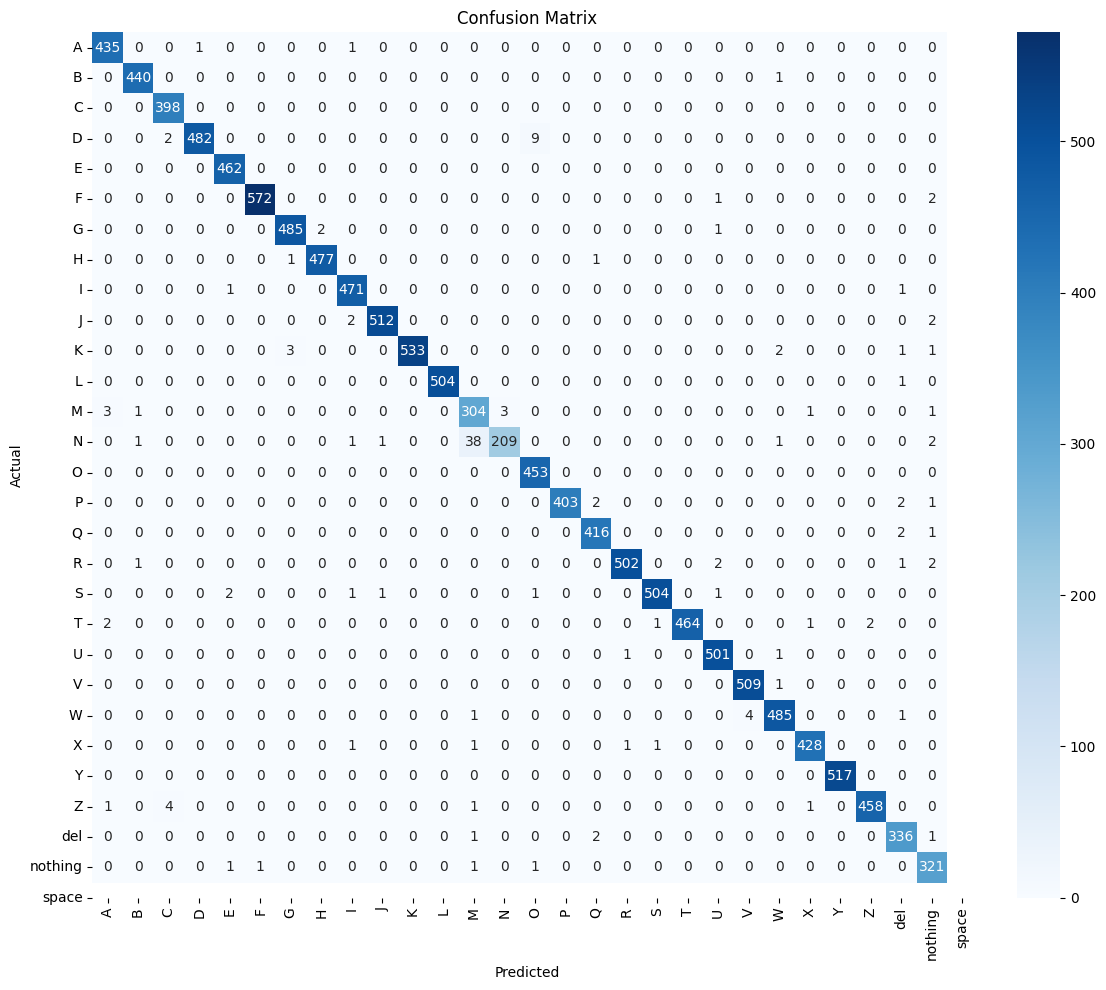

In [11]:
# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Save model
import joblib
model.save('../data/nn_landmark_model.keras')
joblib.dump(label_encoder, '../data/label_encoder.joblib')
joblib.dump(scaler, '../data/scaler.joblib')
print("Model saved!")

Model saved!
